<div style="background-color:rgba(78, 188, 130, 0.05); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(78, 188, 130, 1.0); color: #000000;">

<img src="figs/qr_logo.png" width="700"/>

<h1><strong>Quantum Summer School</strong></h1>

<h2><strong>Episode 5</strong></h2>

<h3><strong>Building Blocks of Quantum Algorithms</strong></h3>

</div>

*In this session, we’ll explore the foundational building blocks of quantum oracles and amplitude amplification.*

<div style="background-color:rgba(255, 248, 240, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 0, 1.0); color: #000000;">

## Objectives
1. Understand what a quantum oracle is and why it's useful
2. Understand how to construct addition and phase flip oracles
3. Explore amplitude amplification

<div/>

## Setup & Imports

In [105]:
from QuantumRingsLib import QuantumRingsProvider, QuantumRegister, ClassicalRegister, QuantumCircuit, job_monitor
# import qiskit versions of QuantumCircuit, QuantumRegister, ClassicalRegister so we can draw statevectors in latex
from qiskit import QuantumCircuit as qkQuantumCircuit
from qiskit import QuantumRegister as qkQuantumRegister
from qiskit import ClassicalRegister as qkClassicalRegister
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from jupyterquiz import display_quiz

  
provider = QuantumRingsProvider(
    token='rings-128.RudMvYqCFOd2CE6mF7G4Xo5NANQKv54K',
    name='i20ph049@phy.svnit.ac.in'
)
backend = provider.get_backend("scarlet_quantum_rings")

## Helper Functions

Bit List: return a list of all bit strings of length num_bits

In [106]:
def bit_list(num_bits):
    bit_strings = [bin(bit)[2:].zfill(num_bits) for bit in range(2**num_bits)]
    bit_lists = []
    for string in bit_strings:
        bit_lists.append([int(bit) for bit in string])
    return  bit_strings, bit_lists

Check Truth Table: supply an oracle which outputs $f(\vec{x})\oplus y$ for a register of length len_x ($\vec{x}$), and use this to check across all possible inputs

In [107]:
def check_truth_table(len_x, oracle):

    print('Oracle:')
    qx = qkQuantumRegister(len_x, 'x')
    qy = qkQuantumRegister(1, 'y')
    qc = qkQuantumCircuit(qy,qx)
    oracle(qc, qx, qy)
    display(qc.draw(reverse_bits=True))

    print('Bit ordering is x_n,...,x_0,y \n')

    basis_states, _ = bit_list(len_x+1)
    for state in basis_states:
        qx = qkQuantumRegister(len_x, 'x')
        qy = qkQuantumRegister(1, 'y')
        qc = qkQuantumCircuit(qy,qx)
        
        for i in range(len_x+1):
            if state[len_x-i] == '1':
                qc.x(i)
        
        sv_in = Statevector(qc)

        oracle(qc, qx, qy)
    
        sv = Statevector(qc)
        print(f"In: \t {sv_in.draw('latex').data[4:4+len_x+1]} \t Out: \t {sv.draw('latex').data[4:4+len_x+1]} \t f+y: \t {sv.draw('latex').data[4+len_x]} \n")
        

## 1. Practice with Conditional Gates

<div style="background-color:rgba(243, 248, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(101, 174, 247, 1.0); color: #000000;">

One of the key components of quantum algorithms is conditional gates. We want to apply *quantum logic* and manipulate bit strings. Remember that our quantum states for an n-qubit system can be expressed in terms of the bit strings of length n. For the case of two qubits, we have:

$$ |\psi\rangle = c_0 |00\rangle + c_1 |01\rangle + c_2 |10\rangle +c_3 |11\rangle  $$

More generally, we can express our quantum state as a sum:

$$ |\psi\rangle = \sum_{x\in\{0,1\}^n}c_x |x\rangle $$

where $\{0,1\}^n$ is a compact notation for all the bit strings of length n. 

Let's practice applying some conditional logic to circuits. In each of the exercises, make sure to not alter the states of any qubits which we don't want altered! Remember that quantum gates are reversible, so you can always undo what you have done.

</div>

In [108]:
backend = provider.get_backend("scarlet_quantum_rings")

**A)** Make a 3-qubit circuit which applies an X gate to qubit 2 if and only if qubit 0 is 0 and qubit 1 is 1.

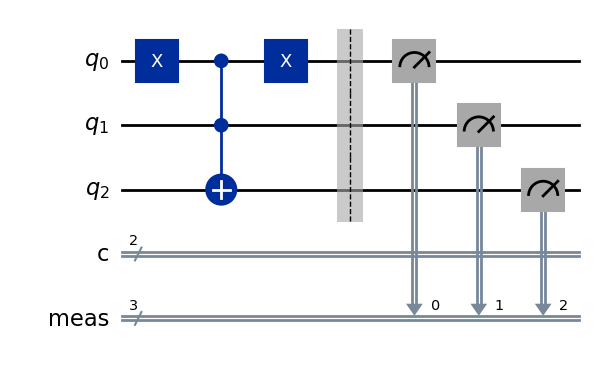

In [109]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3,2)

qc.x(0)

qc.ccx(0, 1, 2)

qc.x(0)

qc.measure_all()

qc.draw(output = 'mpl')


**B)** Make a 3-qubit circuit which applies an X gate to qubit 1 if qubit 2 is in the $|+\rangle$ state and then applies a Z gate to qubit 0 if qubit 1 is in the 1 state.

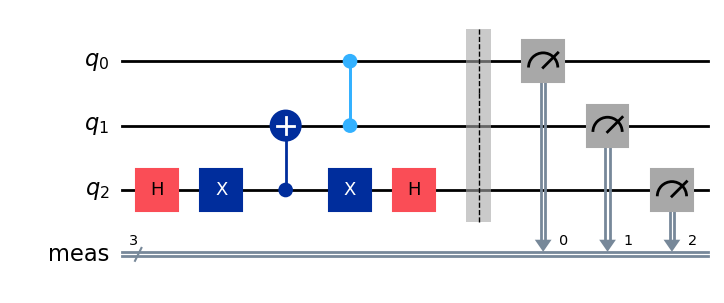

In [110]:
qc = QuantumCircuit(3)

qc.h(2)
qc.x(2)
qc.cx(2,1)
qc.x(2)
qc.h(2)
qc.cz(1,0)

qc.measure_all()

qc.draw('mpl')

# 2. Oracles

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

Oracles are an important building block for quantum computation. An oracle essentially acts as a black box which performs a computation or transforms a quantum state. For example, an oracle might perform addition or flip the phase of a certain basis state. We will explore both of these today.

In future episodes, we will use oracles to help us perform complex quantum algorithms. For today, we want to focus on building an intuition for how an oracle works and why it's useful.

</div>

## Addition Oracle

Let's first consider the case where our oracle $U_f$ performs a classical computation. The possible inputs to the oracle are basis states (such as $|100\rangle$) or superpositions of basis states:

$$ |\psi\rangle = \sum_{x\in\{0,1\}^n}c_x |x\rangle $$

We use an auxillary qubit to help us, which we can call $|y\rangle$. For a given bit string $x$, the oracle takes in $ |x\rangle |y\rangle$ and returns $ |x\rangle |f(x)\oplus y\rangle$, where $\oplus$ denotes binary addition. In more clear notation:

$$ U_f |x\rangle |y\rangle = |x\rangle |f(x)\oplus y\rangle $$

We can practice constructing $U_f$ for single bit input $x$.

**Example 1**

Here is an example of a function $f$ which always outputs 0. The table summarizing for all possible bit combinations is here:

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |0 | 0 | 0 | 0 |
 |0| 1 | 0 | 1 | 
 |1 | 0| 0 | 0 |
 |1| 1| 0 | 1 |

 How do we turn this into a quantum oracle?

In [111]:
## build two quantum registers
qx = qkQuantumRegister(1, 'x')
qy = qkQuantumRegister(1, 'y')

qc = qkQuantumCircuit(qx, qy)


## build oracle

qc.draw()

x: 
   
y:

We can check ourselves with a truthtable.

In [112]:
def oracle(qc, qx, qy):
    # build oracle
    pass

In [113]:
check_truth_table(len_x=1, oracle=oracle)

Oracle:


x: 
   
y:

Bit ordering is x_n,...,x_0,y 

In: 	 00 	 Out: 	 00 	 f+y: 	 0 

In: 	 01 	 Out: 	 01 	 f+y: 	 1 

In: 	 10 	 Out: 	 10 	 f+y: 	 0 

In: 	 11 	 Out: 	 11 	 f+y: 	 1 



**Example 2**

Here is an example which implements the following balanced $f$.

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |0 | 0 | 0 | 0 |
 |0| 1 | 0 | 1 | 
 |1 | 0| 1 | 1 |
 |1| 1| 1 | 0 |

 And this can be implemented by the following circuit:

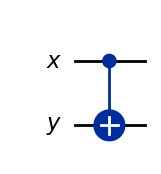

In [114]:
## build two quantum registers
qx = qkQuantumRegister(1, 'x')
qy = qkQuantumRegister(1, 'y')

qc = qkQuantumCircuit(qx, qy)

## build oracle

qc.cx(qx[0],qy[0])

qc.draw(output = 'mpl')

We can check ourselves with a truthtable.

In [115]:
def oracle(qc, qx, qy):
    # build oracle
    qc.cx(qx[0],qy[0])

In [116]:
check_truth_table(len_x=1, oracle=oracle)

Oracle:


x: ──■──
   ┌─┴─┐
y: ┤ X ├
   └───┘

Bit ordering is x_n,...,x_0,y 

In: 	 00 	 Out: 	 00 	 f+y: 	 0 

In: 	 01 	 Out: 	 01 	 f+y: 	 1 

In: 	 10 	 Out: 	 11 	 f+y: 	 1 

In: 	 11 	 Out: 	 10 	 f+y: 	 0 



### Exercises

**A)** Create a circuit which implements $U_f$ for the following $f$:

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |0 | 0 | 1 | 1 |
 |0| 1 | 1 | 0 | 
 |1 | 0| 1 | 1 |
 |1| 1| 1 | 0 |

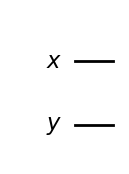

In [117]:
## build two quantum registers
qx = qkQuantumRegister(1, 'x')
qy = qkQuantumRegister(1, 'y')

qc = qkQuantumCircuit(qx, qy)

## build oracle

## Write your code here

qc.draw(output = 'mpl')

In [118]:
def oracle(qc, qx, qy):
    ## your oracle here
    qc.x(qy[0])

In [119]:
check_truth_table(len_x=1, oracle=oracle)

Oracle:


x: ─────
   ┌───┐
y: ┤ X ├
   └───┘

Bit ordering is x_n,...,x_0,y 

In: 	 00 	 Out: 	 01 	 f+y: 	 1 

In: 	 01 	 Out: 	 00 	 f+y: 	 0 

In: 	 10 	 Out: 	 11 	 f+y: 	 1 

In: 	 11 	 Out: 	 10 	 f+y: 	 0 



**B)** Create a circuit which implements $U_f$ for the following $f$:

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |0 | 0 | 1 | 1 |
 |0| 1 | 1 | 0 | 
 |1 | 0| 0 | 0 |
 |1| 1| 0 | 1 |

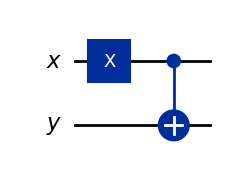

In [120]:
## build two quantum registers
qx = qkQuantumRegister(1, 'x')
qy = qkQuantumRegister(1, 'y')

qc = qkQuantumCircuit(qx, qy)

## build oracle

qc.x(qx[0])
qc.cx(qx[0],qy[0])

## Write your code here

qc.draw(output = 'mpl')

In [121]:
def oracle(qc, qx, qy):
    ## your oracle here
    qc.x(qx[0])
    qc.cx(qx[0],qy[0])

In [122]:
check_truth_table(len_x=1, oracle=oracle)

Oracle:


┌───┐     
x: ┤ X ├──■──
   └───┘┌─┴─┐
y: ─────┤ X ├
        └───┘

Bit ordering is x_n,...,x_0,y 

In: 	 00 	 Out: 	 11 	 f+y: 	 1 

In: 	 01 	 Out: 	 10 	 f+y: 	 0 

In: 	 10 	 Out: 	 00 	 f+y: 	 0 

In: 	 11 	 Out: 	 01 	 f+y: 	 1 



<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Can you build an oracle which implements $U_f$ for the following $f$?

| $x_1$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |$x_0$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x_0,x_1)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x_0,x_1)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- | :-------------------------------- |
 |0 |0 | 0 | 0 | 0 |
 |0 |0| 1 | 0 | 1 | 
 |0 |1 | 0| 1 | 1 |
 |0 |1| 1| 1 | 0 |
 |1 |0 | 0 | 1 | 1 |
 |1 |0| 1 | 1 | 0 | 
 |1 |1 | 0| 0 | 0 |
 |1 |1| 1| 0 | 1 |


Keep in mind the default bit ordering in Qiskit / Quantum Rings. The least significant bit is bit 0 (the top line in our circuits).

<div/>

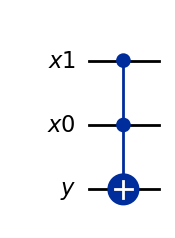

In [123]:
## build two quantum registers
qx1 = qkQuantumRegister(1, 'x1')
qx0 = qkQuantumRegister(1, 'x0')
qy = qkQuantumRegister(1, 'y')

qc = QuantumCircuit(qx1, qx0, qy)

## build oracle

qc.ccx(qx1[0], qx0[0], qy[0])



## Write your code here

qc.draw(output = 'mpl')

In [124]:
def oracle(qc, qx, qy):
    ## your oracle here
    qc.cx(qx,qy)

In [125]:
num_qubits = 2
check_truth_table(len_x=num_qubits, oracle=oracle)

Oracle:


x_1: ───────■──
            │  
x_0: ──■────┼──
     ┌─┴─┐┌─┴─┐
  y: ┤ X ├┤ X ├
     └───┘└───┘

Bit ordering is x_n,...,x_0,y 

In: 	 000 	 Out: 	 000 	 f+y: 	 0 

In: 	 001 	 Out: 	 001 	 f+y: 	 1 

In: 	 010 	 Out: 	 011 	 f+y: 	 1 

In: 	 011 	 Out: 	 010 	 f+y: 	 0 

In: 	 100 	 Out: 	 101 	 f+y: 	 1 

In: 	 101 	 Out: 	 100 	 f+y: 	 0 

In: 	 110 	 Out: 	 110 	 f+y: 	 0 

In: 	 111 	 Out: 	 111 	 f+y: 	 1 



## Phase flip oracle

A phase flip oracle, as the name suggests, flips the phase of a certain state. This is helpful because flipping the phase is a way of marking a state (for example, the correct answer).

First things first, let's understand how a phase-flip oracle is made. Let's start by preparing an equal superposition state by applying a Hadamard to each qubit. Then let's build a phase-flip oracle step-by-step.

Consider a two-qubit system with target state '01'.

In [126]:
target_state = '01'

# Flip target bit-string to match Qiskit bit-ordering
rev_target = target_state[::-1]

num_qubits = len(target_state)

We first apply an X gate to the location of any zeros in our target state. We will still have an equal superposition state after this.

In [127]:
qc = qkQuantumCircuit(num_qubits)

# apply Hadamard to all qubits to be in complete superposition state
qc.h(range(num_qubits))
# Find the indices of all the '0' elements in bit-string and flip
qc.x(1)

qc.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤┌───┐
q_1: ┤ H ├┤ X ├
     └───┘└───┘

We can print out the state vector at the end of the circuit to see what is going on.

In [128]:
display(Statevector(qc).draw('latex'))

<IPython.core.display.Latex object>

Now, let's add a multi-controlled Z gate, which is controlled on the first first qubit and targeted on the second qubit. In practice, it does not matter which qubit is the target or control because the CZ gate behaves symmetrically. The effect of this is it flips the phase of the state with all 1's. This is because we need the first qubit to be 1 for the control condition to be satisfied, and we need the last qubit to be 1 for the Z gate to have a phase flip effect.

In [129]:
qc = qkQuantumCircuit(num_qubits)

# apply Hadamard to all qubits to be in complete superposition state
qc.h(range(num_qubits))
# Find the indices of all the '0' elements in bit-string and flip
qc.x(1)

# apply CZ
qc.cz(0,1)

qc.draw()

┌───┐        
q_0: ┤ H ├──────■─
     ├───┤┌───┐ │ 
q_1: ┤ H ├┤ X ├─■─
     └───┘└───┘

In [130]:
display(Statevector(qc).draw('latex'))

<IPython.core.display.Latex object>

We can see that the $|11\rangle$ state has been phase flipped, as expected.

Now we can apply X gates again to any location of 0 in the target state. This ensures the phase flip is moved back to the target state (instead of staying on $|11\rangle$).

In [131]:
qc = qkQuantumCircuit(num_qubits)

# apply Hadamard to all qubits to be in complete superposition state
qc.h(range(num_qubits))
# Find the indices of all the '0' elements in bit-string and flip
qc.x(1)

# apply CZ
qc.cz(0,1)

# flip all '0' elements again
qc.x(1)

qc.draw()

┌───┐             
q_0: ┤ H ├──────■──────
     ├───┤┌───┐ │ ┌───┐
q_1: ┤ H ├┤ X ├─■─┤ X ├
     └───┘└───┘   └───┘

In [132]:
display(Statevector(qc).draw('latex'))

<IPython.core.display.Latex object>

Ok, great, it works! We got a phase flip on just our target state. So we have successfully built a phase-flip oracle for two qubits.

### Exercise 

**A)** Following the same approach as above, construct an oracle for the target state 00. You can check your work by putting Hadamards on all qubits, then your oracle, and then printing out the final statevector.

In [133]:
qc2 = qkQuantumCircuit(2)

# your code here
qc2.h(range(2))

qc2.cz(0, 1)

qc2.x(0)

qc2.x(1)

display(qc2.draw())

┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ X ├
     ├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ X ├
     └───┘   └───┘

In [134]:
display(Statevector(qc2).draw('latex'))

<IPython.core.display.Latex object>

**B)** Following the same approach as above, but for a 3 qubit system, construct an oracle for the target state 011.

In [135]:
qc3 = qkQuantumCircuit(3)

# your code here
qc3.h(range(3))


qc3.ccz(0, 1, 2)

qc3.x(2)


display(qc3.draw())

┌───┐        
q_0: ┤ H ├─■──────
     ├───┤ │      
q_1: ┤ H ├─■──────
     ├───┤ │ ┌───┐
q_2: ┤ H ├─■─┤ X ├
     └───┘   └───┘

In [136]:
display(Statevector(qc3).draw('latex'))

<IPython.core.display.Latex object>

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Can you make an oracle which flips the phase of two states? See if you can make one which flips the phases of the states encoding bit strings '001' and '101'.

<div/>

In [173]:
qc3 = QuantumCircuit(3)

qc3.h(range(3))  # Apply Hadamard to all qubits to create superposition

qc3.x(1)        # Apply X to q1 to make q1=0 become q1=1
qc3.cz(1, 0)    # Apply CZ with control q1 and target q0; Z on q0 when q1=1 (original q1=0)
qc3.x(1)        # Apply X to q1 again to revert q1 to its original state

display(qc3.draw())

┌───┐             
q_0: ┤ H ├──────■──────
     ├───┤┌───┐ │ ┌───┐
q_1: ┤ H ├┤ X ├─■─┤ X ├
     ├───┤└───┘   └───┘
q_2: ┤ H ├─────────────
     └───┘

In [174]:
display(Statevector(qc3).draw('latex'))

<IPython.core.display.Latex object>

# 2. Amplitude Amplification

<div style="background-color:rgba(255, 245, 253, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 235, 1.0); color: #000000;">

In quantum computing, we know that our final measurement result from our quantum cirucit is *probabalistic*. When we give something to a classical computer to compute, like multiplying two large numbers, it will give us the same answer every time. This is not so for a quantum computer. The goal of a quantum algorithm is to make the amplitude of the correct answer as large as possible and the amplitudes of the wrong answers as small as possible. 

This brings us to another important building block for quantum algorithms: amplitude amplification. It's exactly what it sounds like, it's a step in our quantum algorithm that amplifies the amplitude of the correct answer. And lucky for us, one key ingredient we need for our amplitude amplification is a phase flip oracle!

<div/>

In [142]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

qc = QuantumCircuit(qr, cr, name='QSS5.1_amplitude_amp')

qc.h((qr))

qc.barrier()

# phase flip oracle

qc.barrier()

# diffusion operator
qc.h(qr)
qc.x(qr)
qc.h(2)
qc.ccx(0,1,2)
qc.h(2)
qc.x(qr)
qc.h(qr)

qc.barrier()

# measure
qc.measure(qr,cr)

qc.draw()

┌───┐ ░  ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌─┐      
q3_0: ┤ H ├─░──░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├──────
      ├───┤ ░  ░ ├───┤├───┤       │  ├───┤├───┤      ░ └╥┘┌─┐   
q3_1: ┤ H ├─░──░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├───
      ├───┤ ░  ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║ └╥┘┌─┐
q3_2: ┤ H ├─░──░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
      └───┘ ░  ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
c3: 3/══════════════════════════════════════════════════╩══╩══╩═
                                                        0  1  2

In [161]:
from qiskit_aer import Aer

qr = qkQuantumRegister(3)
cr = qkClassicalRegister(3)
qc = qkQuantumCircuit(qr,cr, name='QSS5.1_amplitude_amp')

# create an equal superposition of all basis states
qc.h((qr))

qc.barrier()

# phase flip oracle
qc.x(1)
qc.ccz(0,1,2)
qc.x(1)

qc.barrier()

# diffusion operator
qc.h(qr)
qc.x(qr)
qc.h(2)
qc.ccx(0,1,2)
qc.h(2)
qc.x(qr)
qc.h(qr)

qc.barrier()

# measure
qc.measure(qr,cr)

qc.draw()

┌───┐ ░               ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌─┐      
q12_0: ┤ H ├─░───────■───────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├──────
       ├───┤ ░ ┌───┐ │ ┌───┐ ░ ├───┤├───┤       │  ├───┤├───┤      ░ └╥┘┌─┐   
q12_1: ┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├───
       ├───┤ ░ └───┘ │ └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║ └╥┘┌─┐
q12_2: ┤ H ├─░───────■───────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
       └───┘ ░               ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
c11: 3/═══════════════════════════════════════════════════════════════╩══╩══╩═
                                                                      0  1  2

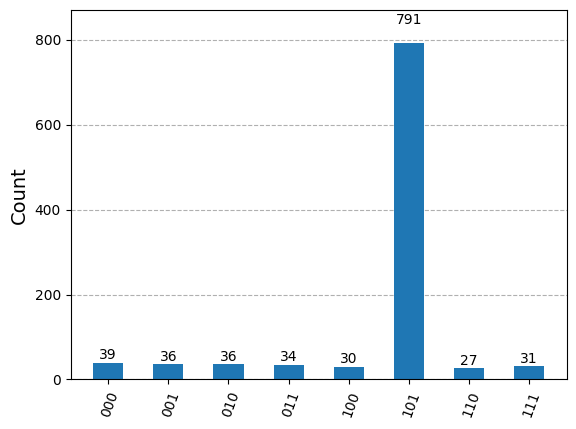

In [162]:
backend = Aer.get_backend('aer_simulator')
job = backend.run(qc, shots=1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

**Question:** What happens if we repeat the amplitude amplification process again?

In [ ]:
from qiskit_aer import Aer

qr = qkQuantumRegister(3)
cr = qkClassicalRegister(3)
qc = qkQuantumCircuit(qr,cr, name='QSS5.1_amplitude_amp')

# create an equal superposition of all basis states
qc.h((qr))

qc.barrier()

# phase flip oracle
qc.x(1)
qc.ccz(0,1,2)
qc.x(1)

qc.barrier()

# diffusion operator
qc.h(qr)
qc.x(qr)
qc.h(2)
qc.ccx(0,1,2)
qc.h(2)
qc.x(qr)
qc.h(qr)

qc.barrier()

# Again repeat this (second time)

# phase flip oracle
qc.x(1)
qc.ccz(0,1,2)
qc.x(1)

qc.barrier()

# diffusion operator
qc.h(qr)
qc.x(qr)
qc.h(2)
qc.ccx(0,1,2)
qc.h(2)
qc.x(qr)
qc.h(qr)

qc.barrier()

# measure
qc.measure(qr,cr)

qc.draw()

┌───┐ ░               ░ ┌───┐┌───┐          ┌───┐┌───┐      ░         »
q13_0: ┤ H ├─░───────■───────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───────■─»
       ├───┤ ░ ┌───┐ │ ┌───┐ ░ ├───┤├───┤       │  ├───┤├───┤      ░ ┌───┐ │ »
q13_1: ┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤ X ├─■─»
       ├───┤ ░ └───┘ │ └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░ └───┘ │ »
q13_2: ┤ H ├─░───────■───────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░───────■─»
       └───┘ ░               ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░         »
c12: 3/══════════════════════════════════════════════════════════════════════»
                                                                             »
«             ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌─┐      
«q13_0: ──────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├──────
«       ┌───┐ ░ ├───┤├───┤       │  ├───┤├───┤      ░ └╥┘┌─┐   
«q13_1: ┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├───
«       └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║ └╥┘┌─┐
«q13_2: ──────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
«             ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
«c12: 3/═══════════════════════════════════════════════╩══╩══╩═
«                                                      0  1  2

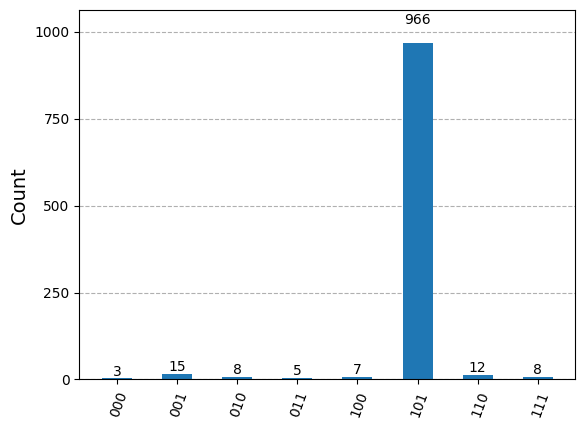

In [164]:
job = backend.run(qc, shots=1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

What happens if you repeat the amplitude amplification three times? Try it out!

<div/>

In [182]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# Create quantum and classical registers
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qr, cr, name='amplitude_amplification')

# Step 1: Initial superposition
qc.h(qr)

# Step 2: Apply amplitude amplification n times
def amplitude_amplification(qc, qr, n):
    for _ in range(n):
        # Phase flip oracle
        qc.x(1)
        qc.ccz(0, 1, 2)
        qc.x(1)
        
        # Optional barrier for visualization
        qc.barrier()
        
        # Diffusion operator
        qc.h(qr)
        qc.x(qr)
        qc.h(2)
        qc.ccx(0, 1, 2)
        qc.h(2)
        qc.x(qr)
        qc.h(qr)
        
        # Optional barrier for visualization
        qc.barrier()

# Example: Apply amplitude amplification for n repetitions
n = 3  # Replace with desired number of repetitions
amplitude_amplification(qc, qr, n)

# Step 3: Measure
qc.measure(qr, cr)

# Optional: Draw the circuit
print(qc.draw())

     ┌───┐              ░ ┌───┐┌───┐          ┌───┐┌───┐      ░              »
q_0: ┤ H ├──────■───────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───────■──────»
     ├───┤┌───┐ │ ┌───┐ ░ ├───┤├───┤       │  ├───┤├───┤      ░ ┌───┐ │ ┌───┐»
q_1: ┤ H ├┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤ X ├─■─┤ X ├»
     ├───┤└───┘ │ └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░ └───┘ │ └───┘»
q_2: ┤ H ├──────■───────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░───────■──────»
     └───┘              ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░              »
c: 3/════════════════════════════════════════════════════════════════════════»
                                                                             »
«      ░ ┌───┐┌───┐          ┌───┐┌───┐      ░               ░ ┌───┐┌───┐     »
«q_0: ─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───────■───────░─┤ H ├┤ X ├─────»
«      ░ ├───┤├───┤       │  ├───┤├───┤      ░ ┌───┐ │ ┌───┐ ░ ├───┤├───┤     »
«q_1: ─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤ 

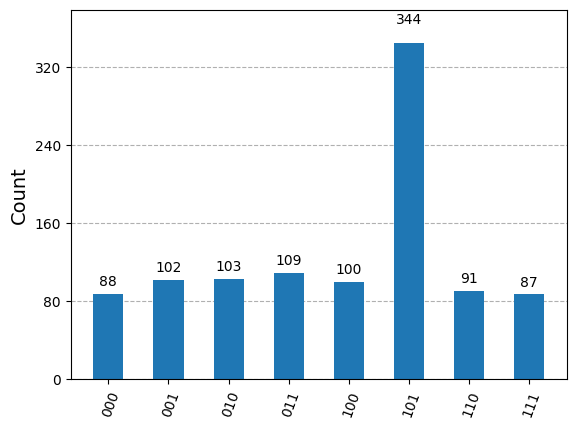

In [183]:
job = backend.run(qc, shots=1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

### Check your understanding

<div class="ques1" style="display:none">
[
  {
    "question": "What is the role of an oracle in quantum computing?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"Performing a computation or transforming a quantum state","correct":true,  "feedback":"✅ We saw example of each of these today"},
      {"answer":"Predicting the future","correct":false, "feedback":"❌"},
        {"answer":"Flipping the phase of a desired state","correct":false, "feedback":"❌ This could be an example of an oracle, but you can use oracles for all kinds of things"},
    {"answer":"Measuring the quantum state","correct":false, "feedback":"❌"}
    ]
  }   
]
</div>

<div class="ques2" style="display:none">
[
  {
    "question": "Is a quantum oracle a unitary operation?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"Yes","correct":true,  "feedback":"✅ An oracle transforms one quantum state to another using quantum gates, so it must be reversible (and unitary)."},
      {"answer":"No","correct":false, "feedback":"❌"}
    ]
  }   
]
</div>

<div class="ques3" style="display:none">
[
  {
    "question": "What happens if you keep doing amplitude amplification?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"The correct state will increase in amplitude but then decrease again after it reaches its peak amplitude","correct":true,  "feedback":"✅ Amplitude amplification is a reflection about the mean amplitude. If we keep doing it too much, the largest amplitude state will start decreasing again."},
      {"answer":"Eventually, the correct state will have amplitude 1 and all others will have amplitude 0","correct":false, "feedback":"❌"},
    {"answer":"The correct state reaches some amplitude close to one but plateaus and can never reach one.","correct":false, "feedback":"❌"},
    {"answer":"Eventually the amplitudes of all states will be equal","correct":false, "feedback":"❌"}
    ]
  }   
]
</div>

In [ ]:
display_quiz("#ques1")
display_quiz("#ques2")
display_quiz("#ques3")